In [ ]:
import json
import pandas as pd
import random

# Load the CSV file
csv_path = 'D:/archive/turtles-data/data/metadata_splits.csv'  # Ensure the path is correct
df = pd.read_csv(csv_path)

# Load the original JSON file
json_path = 'D:/archive/turtles-data/data/annotations.json'  # Ensure the path is correct
with open(json_path, 'r') as f:
    data = json.load(f)

# Set a random seed to ensure reproducible results
random.seed(42)

# Get the image IDs for each split in the CSV file and randomly select 60%
def get_random_sample_ids(df, split_name):
    ids = list(set(df[df['split_open'] == split_name]['id']))
    sample_size = int(len(ids) * 0.6)
    return set(random.sample(ids, sample_size))

train_ids = get_random_sample_ids(df, 'train')
test_ids = get_random_sample_ids(df, 'test')
valid_ids = get_random_sample_ids(df, 'valid')

# Separate image and annotation data
train_images = [img for img in data['images'] if img['id'] in train_ids]
test_images = [img for img in data['images'] if img['id'] in test_ids]
valid_images = [img for img in data['images'] if img['id'] in valid_ids]

train_annotations = [ann for ann in data['annotations'] if ann['image_id'] in train_ids]
test_annotations = [ann for ann in data['annotations'] if ann['image_id'] in test_ids]
valid_annotations = [ann for ann in data['annotations'] if ann['image_id'] in valid_ids]

# Retain the original categories and license information
categories = data['categories']
licenses = data.get('licenses', [])

# Construct the JSON structure for the training, test, and validation sets
train_data = {
    "images": train_images,
    "annotations": train_annotations,
    "categories": categories,
    "licenses": licenses
}

test_data = {
    "images": test_images,
    "annotations": test_annotations,
    "categories": categories,
    "licenses": licenses
}

valid_data = {
    "images": valid_images,
    "annotations": valid_annotations,
    "categories": categories,
    "licenses": licenses
}

# Save the training, test, and validation JSON files
output_dir = 'D:/archive/turtles-data/data/'
with open(output_dir + 'annotations_train.json', 'w') as f:
    json.dump(train_data, f)

with open(output_dir + 'annotations_test.json', 'w') as f:
    json.dump(test_data, f)

with open(output_dir + 'annotations_valid.json', 'w') as f:
    json.dump(valid_data, f)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=4):
        super(UNet, self).__init__()
        
        # Define the U-Net encoder part
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Max pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Define the U-Net bottleneck part
        self.bottleneck = self.conv_block(512, 1024)
        
        # Define the U-Net decoder part
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        
        # Final output layer
        self.conv_final = nn.Conv2d(64, out_channels, kernel_size=1)
        
   
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder part
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))
        
        # Decoder part
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        return self.conv_final(dec1)


In [36]:
import json
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from pycocotools import mask as coco_mask 



class TurtleSegmentationDataset(Dataset):
    def __init__(self, annotations_file, images_dir, transform=None):
        with open(annotations_file, 'r') as f:
            self.data = json.load(f)
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.data['images'])

    def __getitem__(self, idx):
        # Get image info and path
        image_info = self.data['images'][idx]
        image_path = os.path.join(self.images_dir, image_info['file_name'])
        image = Image.open(image_path).convert("RGB")
        
        # Initialize category masks
        mask_category1 = np.zeros((image_info['height'], image_info['width']), dtype=bool)
        mask_category2 = np.zeros((image_info['height'], image_info['width']), dtype=bool)
        mask_category3 = np.zeros((image_info['height'], image_info['width']), dtype=bool)

        # Iterate over segmentation annotations and generate masks for each category
        for ann in self.data['annotations']:
            if ann['image_id'] == image_info['id']:
                rle = ann['segmentation']
                category_id = ann['category_id']
                
                # Convert RLE to binary mask
                rle_encoded = coco_mask.frPyObjects(rle, image_info['height'], image_info['width'])
                binary_mask = coco_mask.decode(rle_encoded).astype(bool)
                
                # Assign to the corresponding mask based on category_id
                if category_id == 1:
                    mask_category1 |= binary_mask
                elif category_id == 2:
                    mask_category2 |= binary_mask
                elif category_id == 3:
                    mask_category3 |= binary_mask

        # Compute refined_mask_category1 by excluding regions of category 2 and category 3
        refined_mask_category1 = mask_category1 & ~mask_category2 & ~mask_category3

        # Create a final mask image
        final_mask = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
        final_mask[refined_mask_category1] = 1  # Use 1 to represent refined category 1
        final_mask[mask_category2] = 2          # Use 2 to represent category 2
        final_mask[mask_category3] = 3          # Use 3 to represent category 3

        # Resize the image and mask
        image = image.resize((256, 256))
        final_mask = Image.fromarray(final_mask).resize((256, 256), resample=Image.NEAREST)

        # Apply transformations
        if self.transform:
            image = self.transform(image)
        final_mask = torch.from_numpy(np.array(final_mask)).long()
        
        return image, final_mask



transform = transforms.Compose([
    transforms.ToTensor()
])

# Load training and testing datasets
train_dataset = TurtleSegmentationDataset(
    annotations_file='/root/autodl-fs/archive/turtles-data/data/annotations_train.json',
    images_dir='/root/autodl-fs/archive/turtles-data/data',
    transform=transform
)

test_dataset = TurtleSegmentationDataset(
    annotations_file='/root/autodl-fs/archive/turtles-data/data/annotations_test.json',
    images_dir='/root/autodl-fs/archive/turtles-data/data',
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=8)


In [8]:
# Create U-Net model
model = UNet(in_channels=3, out_channels=4)  # Assuming 4 classes for segmentation (background + 3 parts)

import torch.nn as nn
import torch.optim as optim

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("training finished")

# Save model weights
torch.save(model.state_dict(), "turtle_segmentation_unet.pth")
print("model weights saved")


Epoch [1/30], Loss: 0.4494
Epoch [2/30], Loss: 0.3114
Epoch [3/30], Loss: 0.2503
Epoch [4/30], Loss: 0.2246
Epoch [5/30], Loss: 0.2021
Epoch [6/30], Loss: 0.1820
Epoch [7/30], Loss: 0.1613
Epoch [8/30], Loss: 0.1393
Epoch [9/30], Loss: 0.1280
Epoch [10/30], Loss: 0.1166
Epoch [11/30], Loss: 0.1073
Epoch [12/30], Loss: 0.1011
Epoch [13/30], Loss: 0.0940
Epoch [14/30], Loss: 0.0895
Epoch [15/30], Loss: 0.0835
Epoch [16/30], Loss: 0.0810
Epoch [17/30], Loss: 0.0739
Epoch [18/30], Loss: 0.0715
Epoch [19/30], Loss: 0.0700
Epoch [20/30], Loss: 0.0651
Epoch [21/30], Loss: 0.0601
Epoch [22/30], Loss: 0.0583
Epoch [23/30], Loss: 0.0532
Epoch [24/30], Loss: 0.0579
Epoch [25/30], Loss: 0.0498
Epoch [26/30], Loss: 0.0478
Epoch [27/30], Loss: 0.0465
Epoch [28/30], Loss: 0.0432
Epoch [29/30], Loss: 0.0406
Epoch [30/30], Loss: 0.0425
training finished
model weights saved


image 1: shell: 0.9612538093164997    fin: 0.8461538461538461    head: 0.7843137254901961


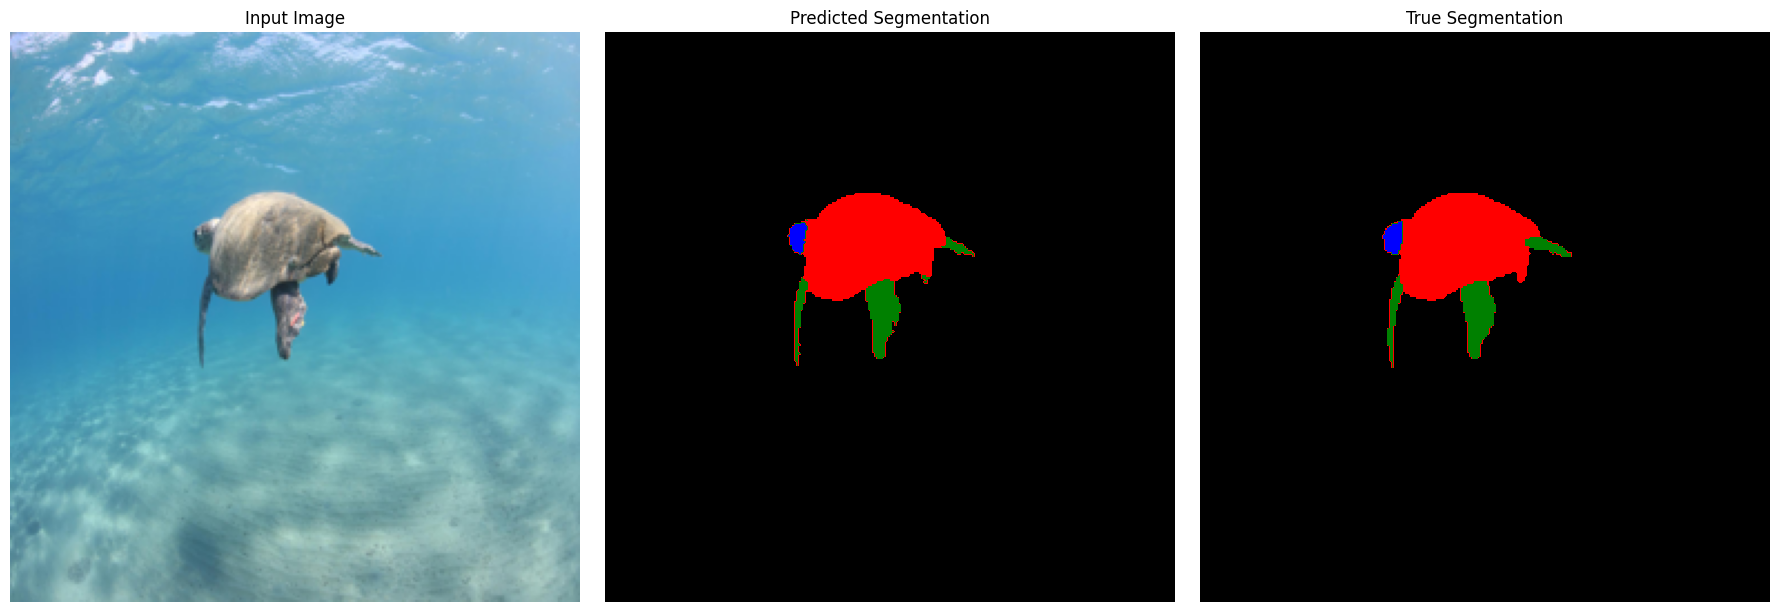

image 2: shell: 0.972243940578577    fin: 0.9130434782608695    head: 0.8782051282051282


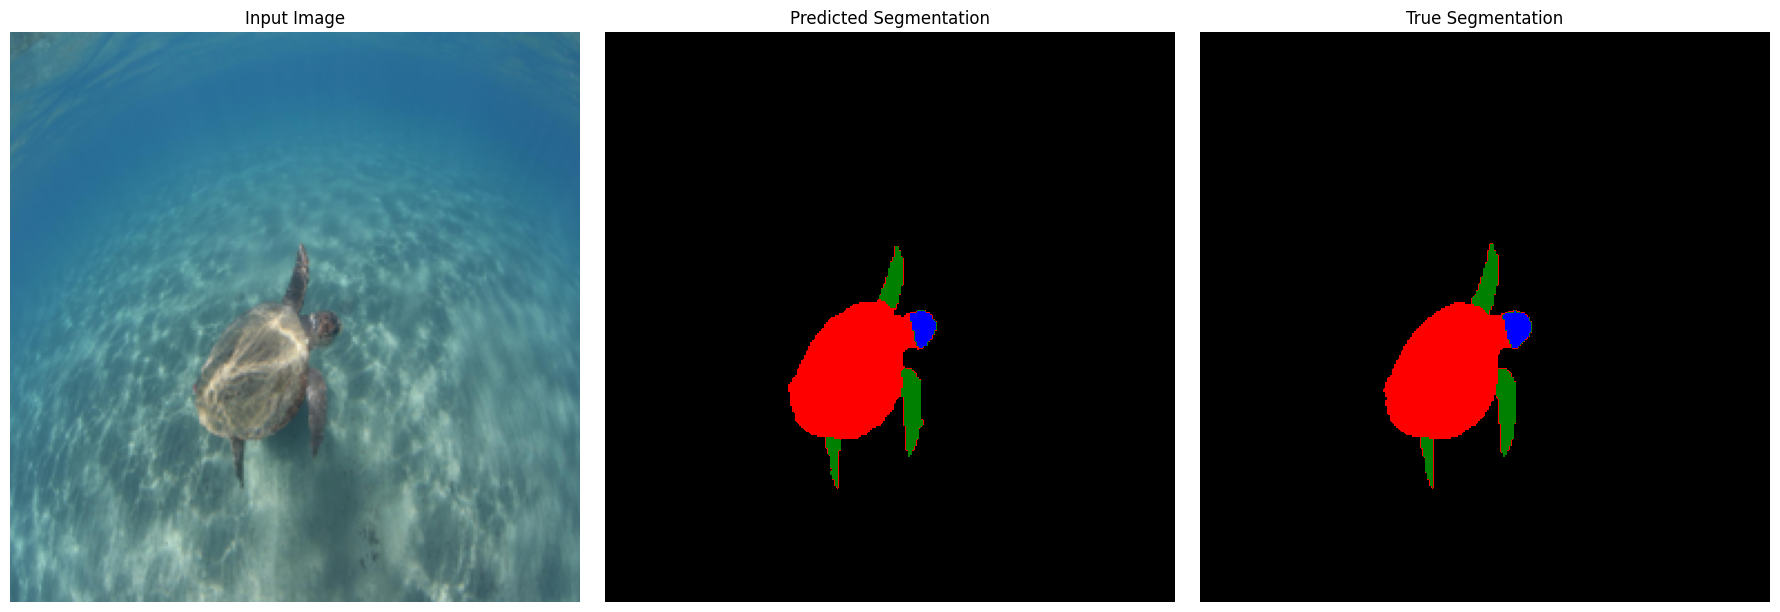

image 3: shell: 0.8937429988798208    fin: 0.7592809691285658    head: 0.9049394221808015


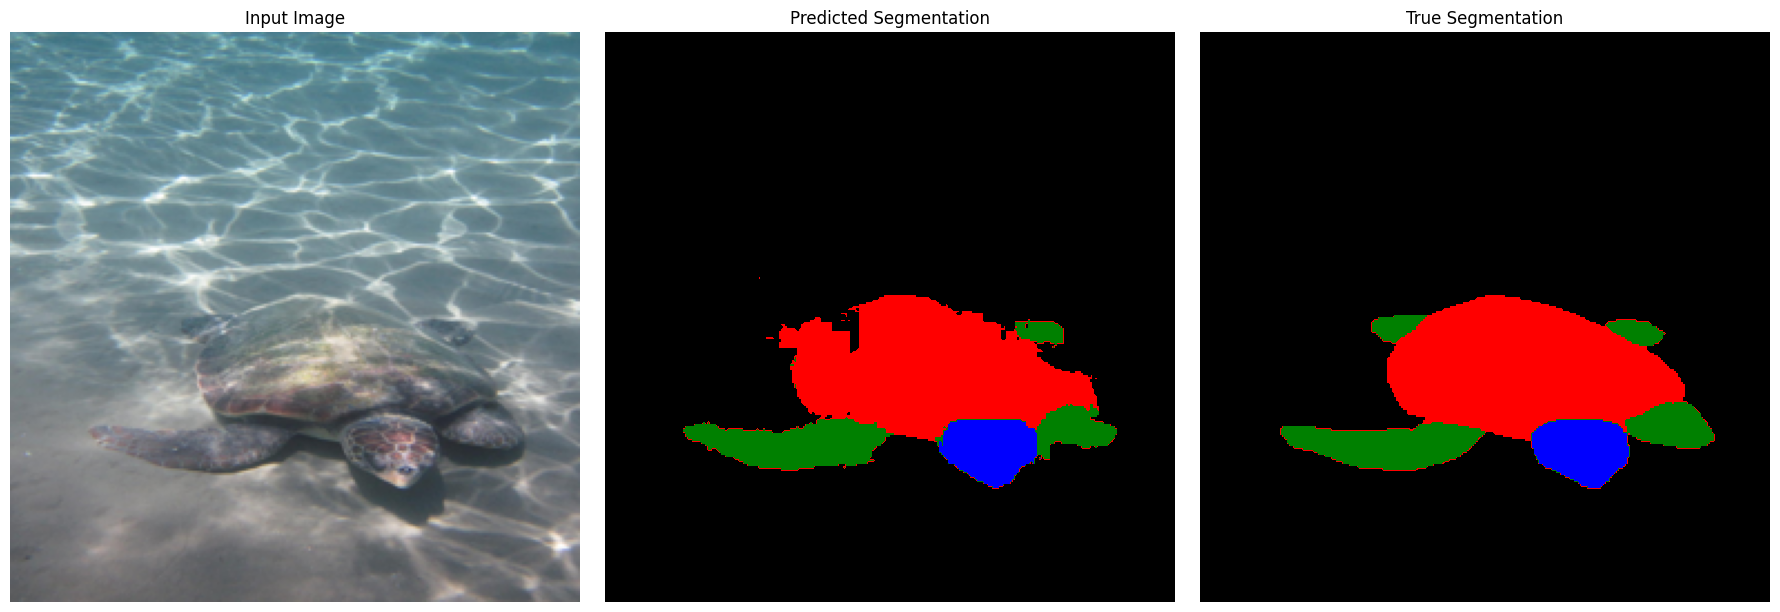

image 4: shell: 0.8684826558842307    fin: 0.6409140369967355    head: 0.7304964539007093


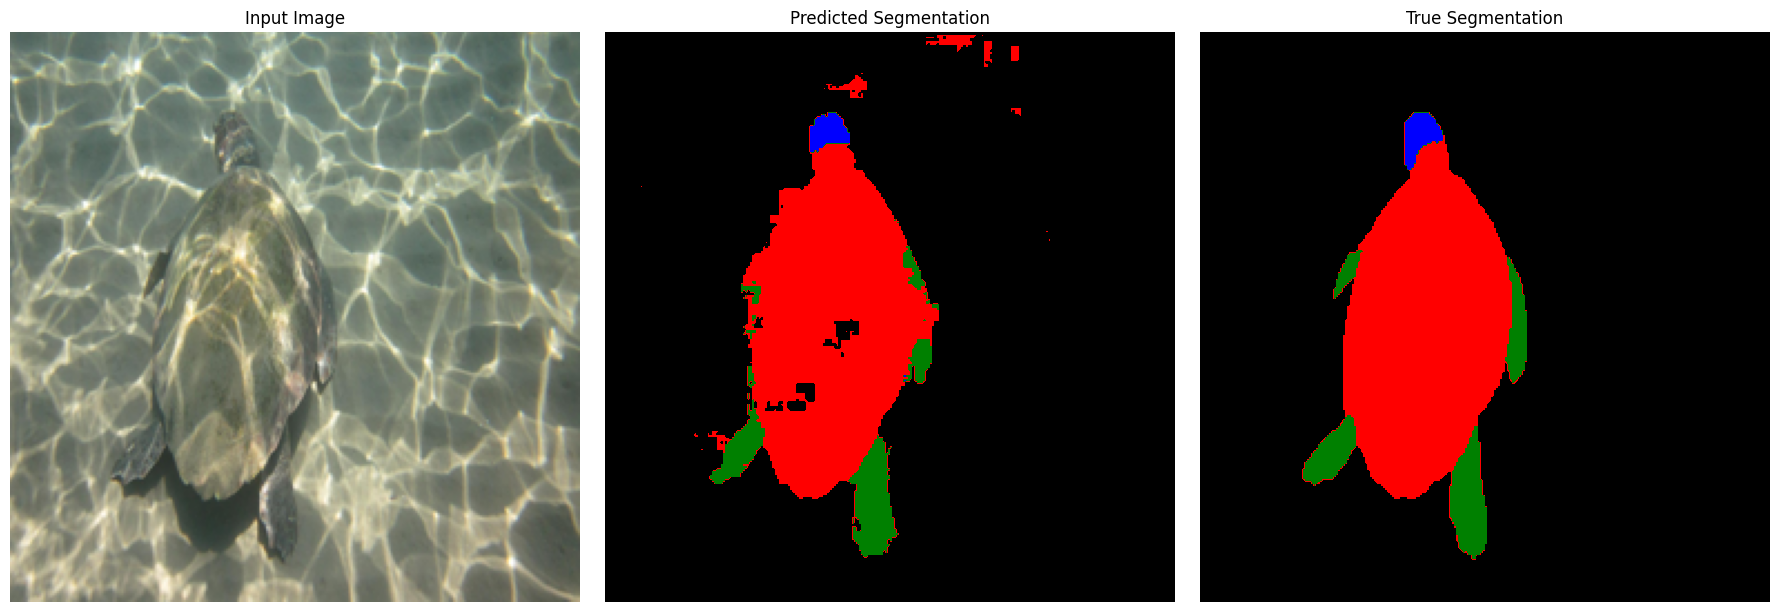

image 5: shell: 0.9683214719666724    fin: 0.930342143003483    head: 0.9261904761904762


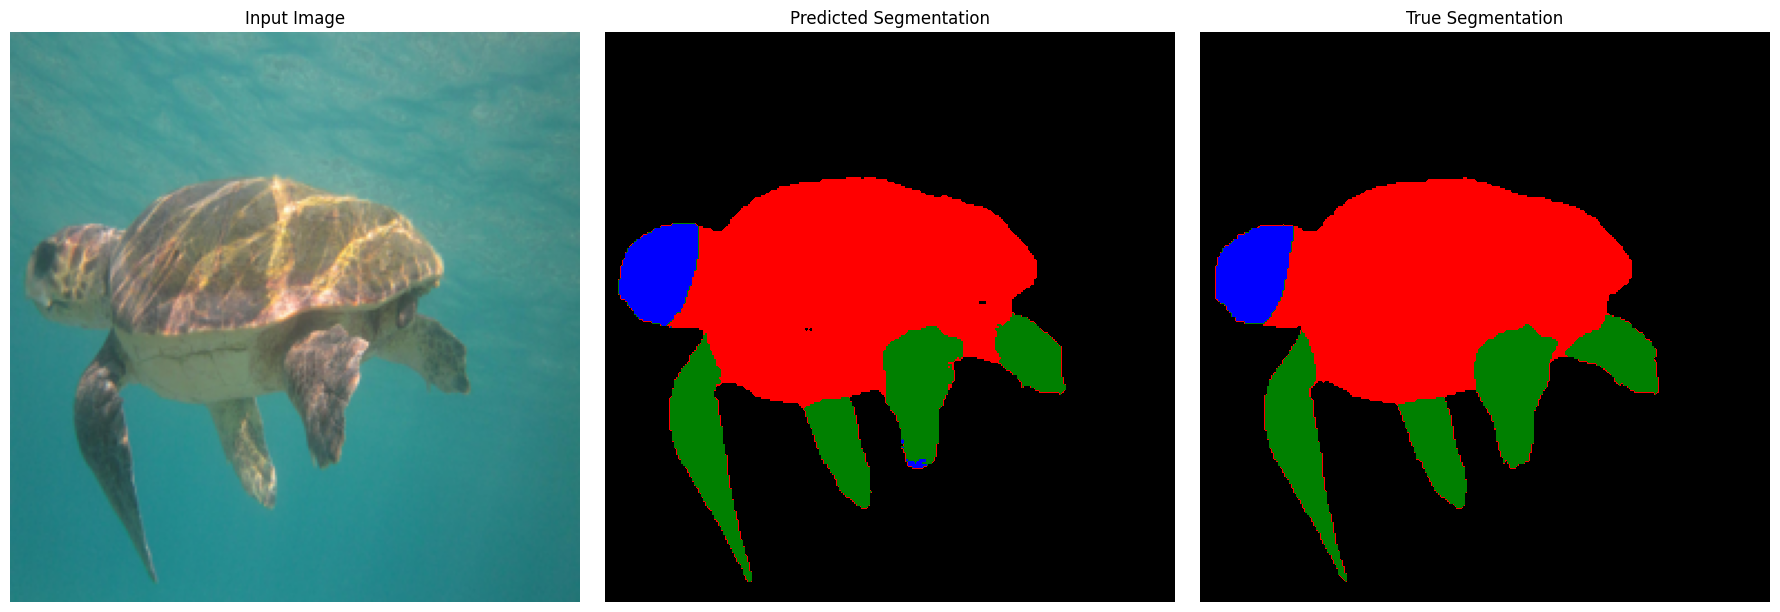

image 6: shell: 0.9206474190726159    fin: 0.8372093023255814    head: 0.8178104575163399


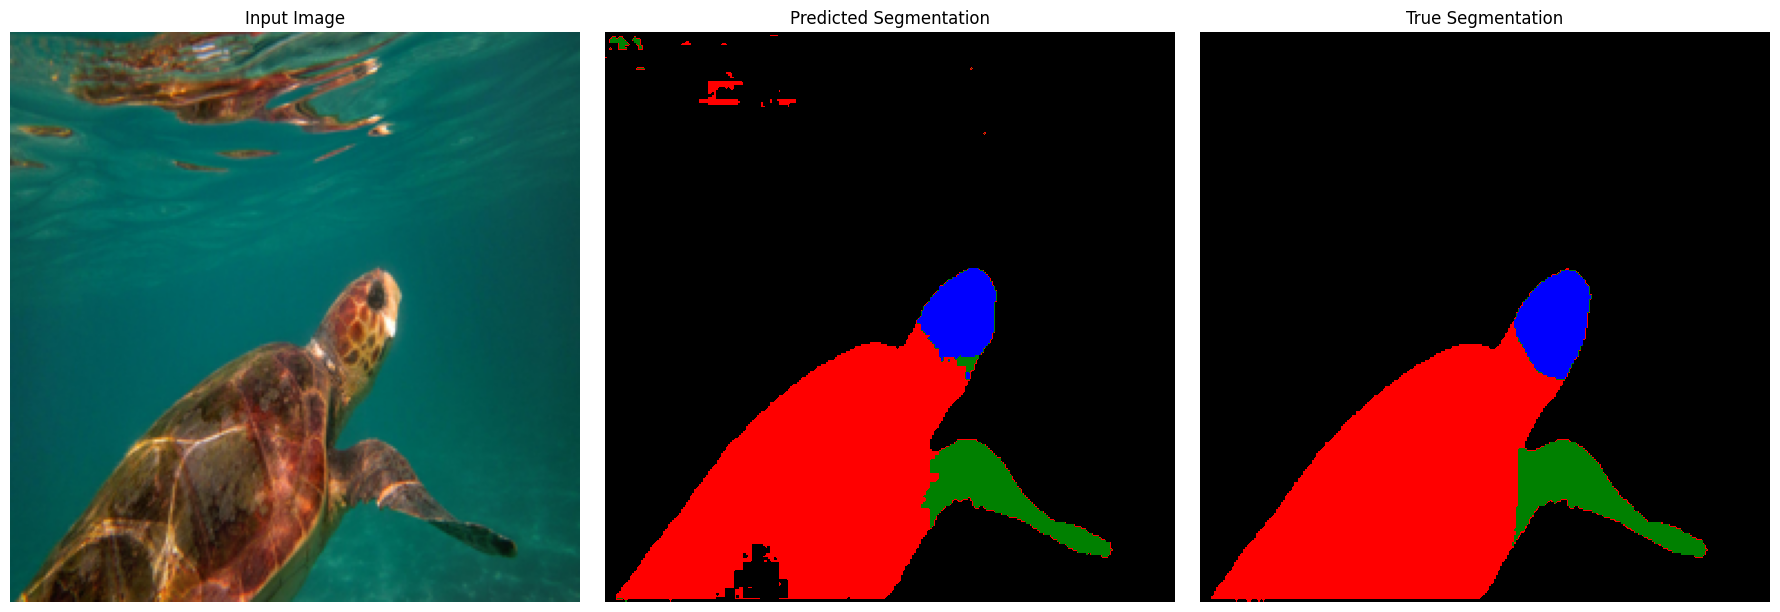

image 7: shell: 0.9223895582329317    fin: 0.7911576497963932    head: 0.8344246959775491


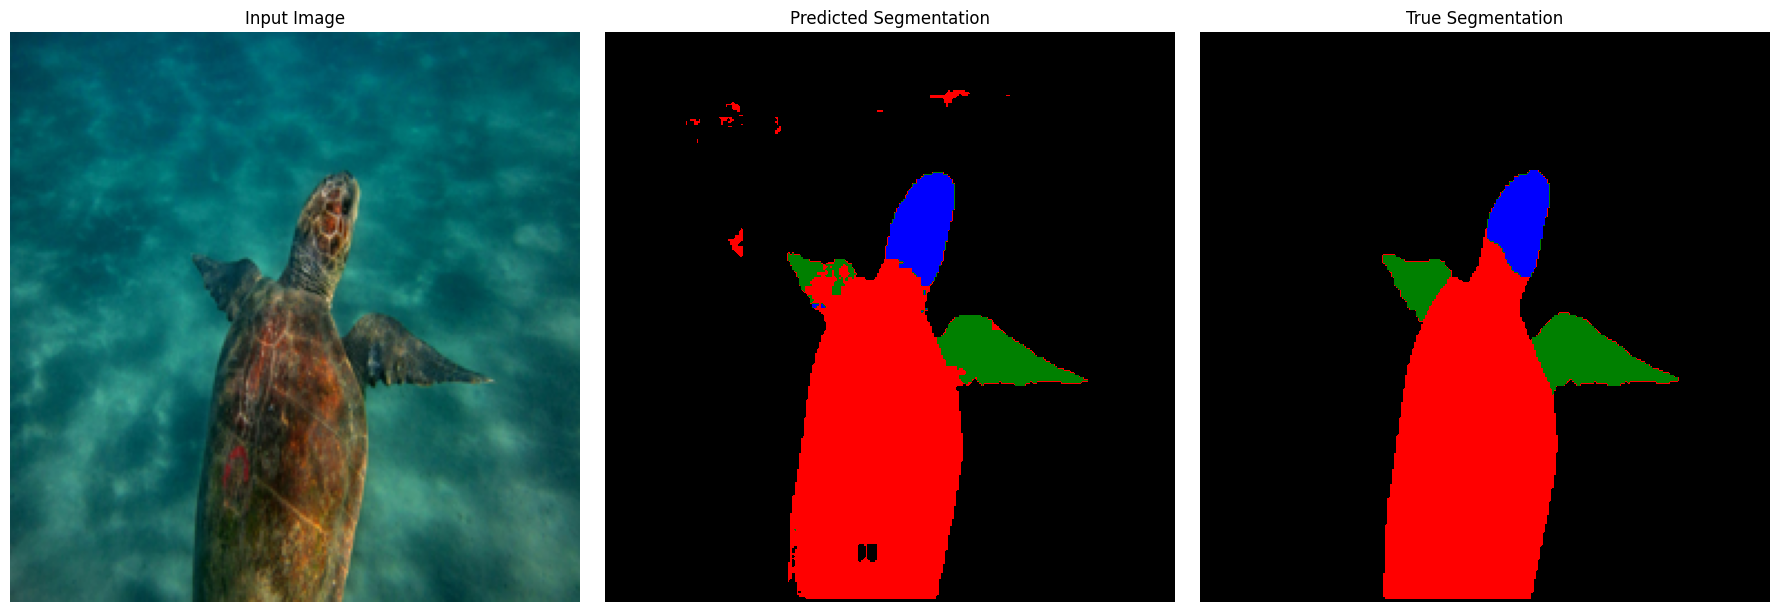

image 8: shell: 0.8069113890009413    fin: 0.8746529155097184    head: 0.8632286995515696


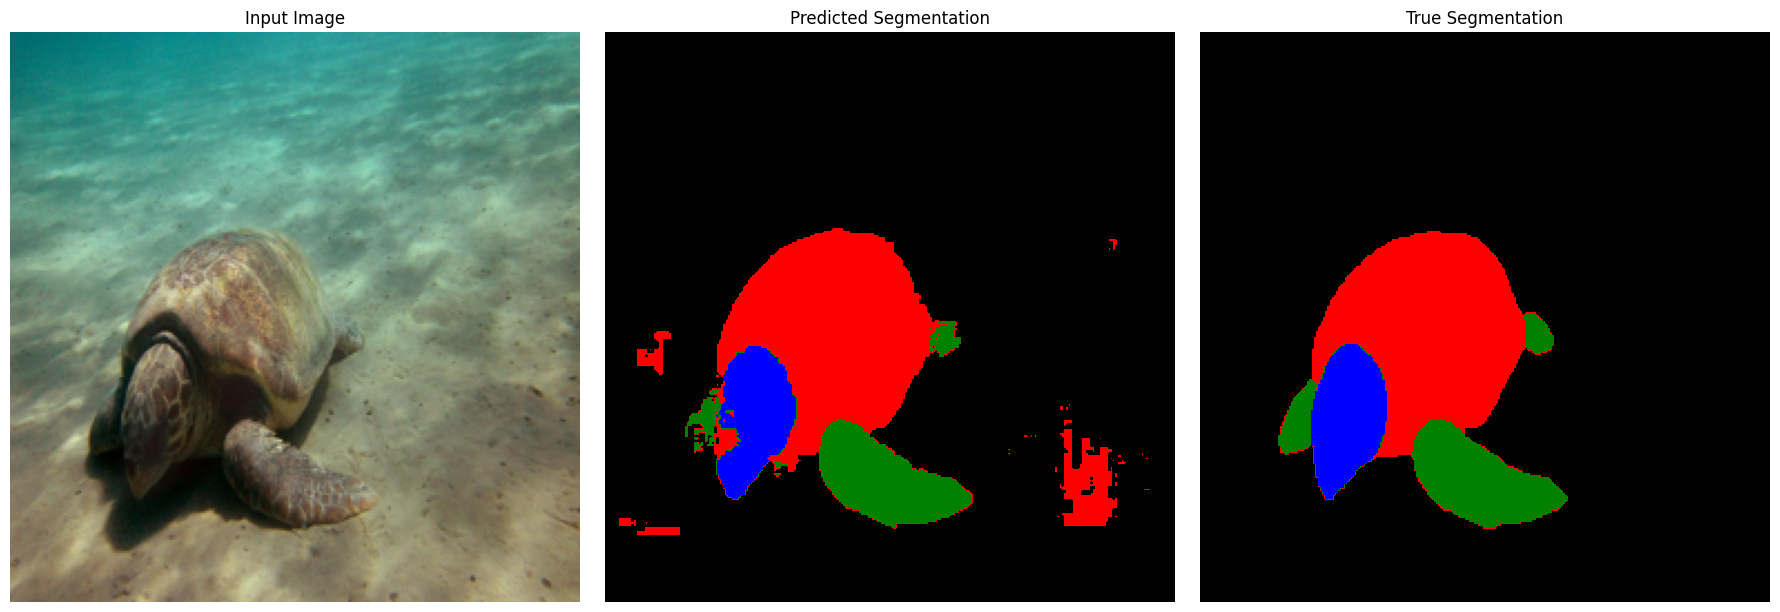

image 9: shell: 0.9349843587069865    fin: 0.921046258173892    head: 0.7611301369863014


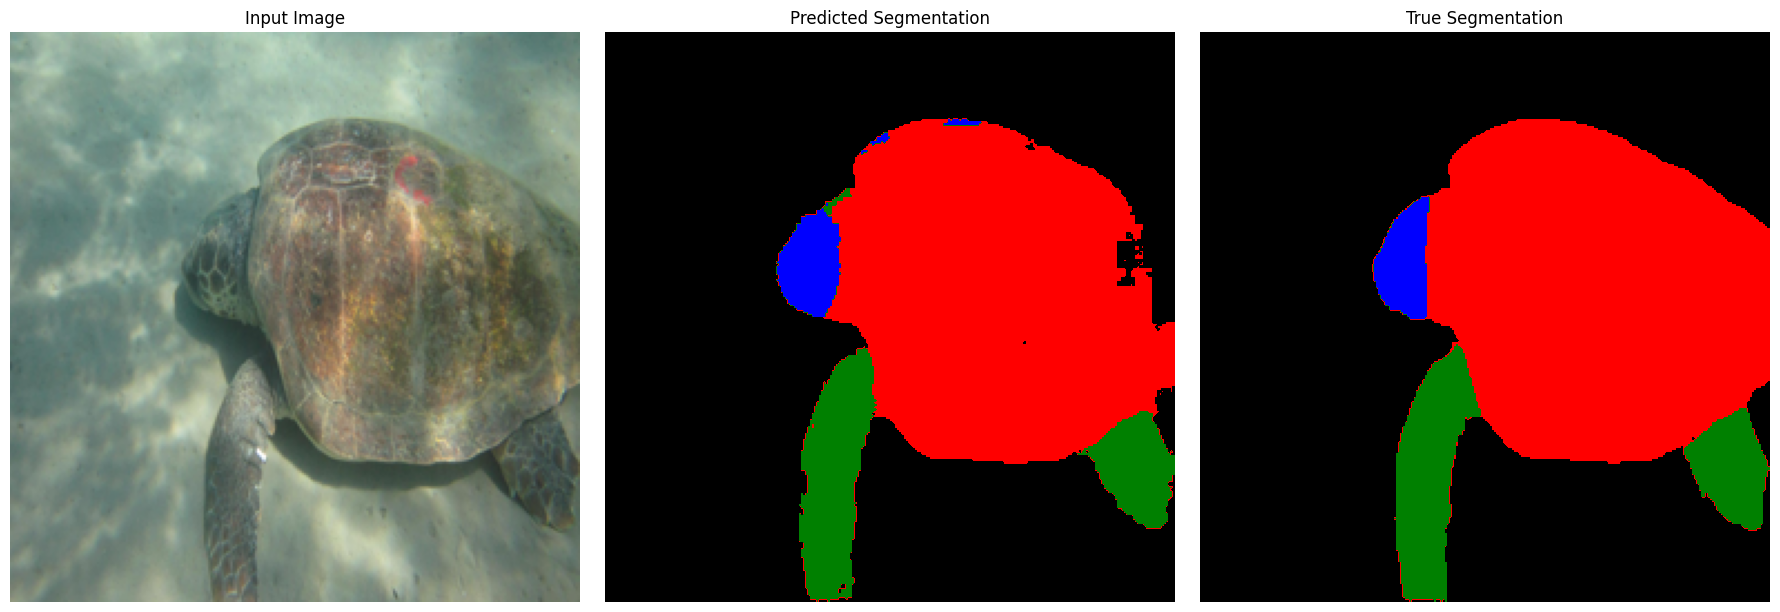

Mean IoU for each class (include background class): [0.98917943 0.84934243 0.75176769 0.75698193]
Mean IoU across all classes (exclude background class): 0.7860306860358314


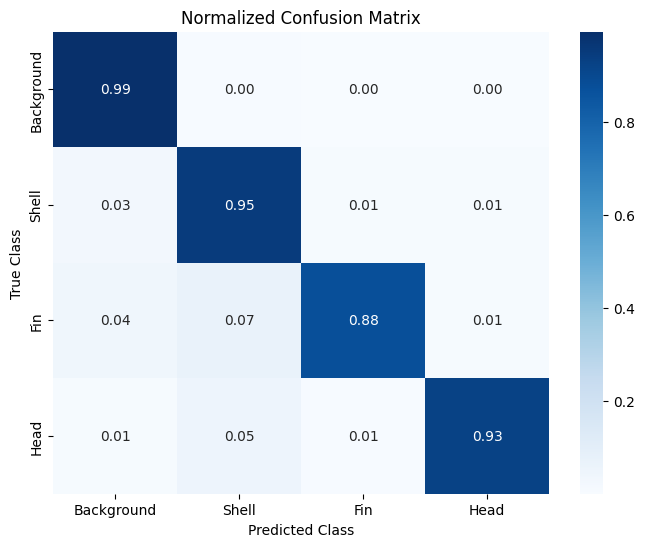

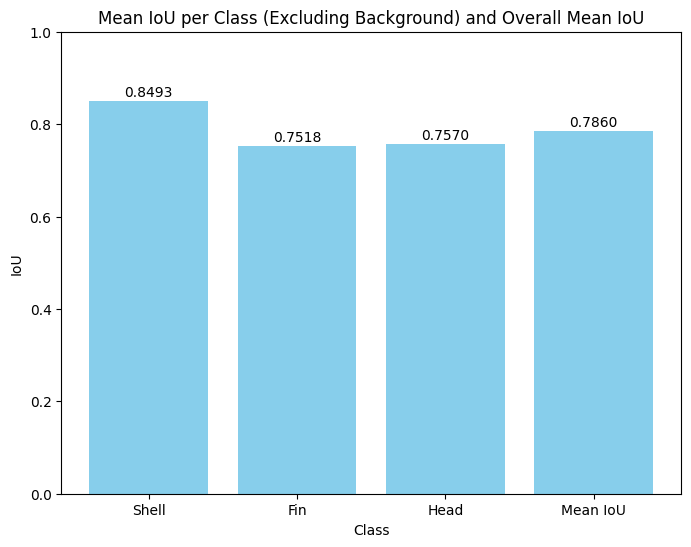

In [40]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
import seaborn as sns

 # Assuming 4 classes for segmentation (background + 3 parts)
model = UNet(in_channels=3, out_channels=4)  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load model weights
model.load_state_dict(torch.load("turtle_segmentation_unet.pth"))
model.eval()  # 切换到评估模式

# Define colors for each class (assuming 4 classes: 0, 1, 2, 3)
class_colors = ['black', 'red', 'green', 'blue']
cmap = ListedColormap(class_colors)

# Define function to display overall segmentation result on an image
def visualize_segmentation(image, pred_mask, true_mask, sample_idx):
    image_np = image.permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C)
    pred_mask_np = pred_mask.cpu().numpy()
    true_mask_np = true_mask.cpu().numpy()

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(image_np)
    ax[0].set_title("Input Image")

    ax[1].imshow(pred_mask_np, cmap=cmap, vmin=0, vmax=len(class_colors) - 1)
    ax[1].set_title("Predicted Segmentation")

    ax[2].imshow(true_mask_np, cmap=cmap, vmin=0, vmax=len(class_colors) - 1)
    ax[2].set_title("True Segmentation")

    for a in ax:
        a.axis("off")
    plt.tight_layout()
    plt.show()

category_names = ['shell', 'fin', 'head']
# Calculate IoU and confusion matrix
def calculate_iou(pred_mask, true_mask, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_inds = (pred_mask == cls)
        target_inds = (true_mask == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))  # Ignore background class
        else:
            ious.append(intersection / union)
    return ious

total_ious = []
conf_matrix_total = np.zeros((4, 4), dtype=int)  # Assuming 4 classes, including background

with torch.no_grad():  
    for batch_idx, (images, masks) in enumerate(test_loader):
        images = images.to(device)
        masks = masks.to(device)
        
        # Get model predictions
        outputs = model(images)
        pred_masks = torch.argmax(outputs, dim=1)  # Get class predictions
        
        # Calculate IoU for each image and display segmentation results
        for i in range(images.size(0)):
            pred_mask_flat = pred_masks[i].cpu().numpy().flatten()
            true_mask_flat = masks[i].cpu().numpy().flatten()
            
            # Calculate and record IoU
            ious = calculate_iou(pred_masks[i].cpu(), masks[i].cpu(), num_classes=4)
            total_ious.append(ious)
            printout = "    ".join([f"{category_names[i-1]}: {ious[i]}" for i in range(1,len(ious))])
            if (batch_idx * test_loader.batch_size + i + 1) < 10:
                print(f"image {batch_idx * test_loader.batch_size + i + 1}: {printout}")

            # Update confusion matrix
            conf_matrix = confusion_matrix(true_mask_flat, pred_mask_flat, labels=range(4))
            conf_matrix_total += conf_matrix

            # Visualize overall segmentation result
            if (batch_idx * test_loader.batch_size + i + 1) < 10:
                visualize_segmentation(images[i], pred_masks[i], masks[i], sample_idx=batch_idx * test_loader.batch_size + i + 1)
     

                
# Calculate mean IoU across all samples
total_ious = np.array(total_ious)
mean_iou = np.nanmean(total_ious, axis=0)  # 对每个类别的 IoU 取平均
print(f"Mean IoU for each class (include background class): {mean_iou}")
print(f"Mean IoU across all classes (exclude background class): {np.nanmean(mean_iou[1:])}")

# Plot confusion matrix
conf_matrix_normalized = conf_matrix_total.astype('float') / conf_matrix_total.sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Background', 'Shell', 'Fin', 'Head'],
            yticklabels=['Background', 'Shell', 'Fin', 'Head'])
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Normalized Confusion Matrix")
plt.show()

# remove Background class，and calculate mean of mean ious
categories = ['Shell', 'Fin', 'Head']
mean_iou_without_background = mean_iou[1:]  # Exclude Background class
mean_iou_with_mean = list(mean_iou_without_background) + [np.nanmean(mean_iou_without_background)]

# add "Mean IoU" to class label
categories_with_mean = categories + ['Mean IoU']

# plot IoU 
plt.figure(figsize=(8, 6))
bars = plt.bar(categories_with_mean, mean_iou_with_mean, color='skyblue')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center')
plt.ylim(0, 1)
plt.xlabel("Class")
plt.ylabel("IoU")
plt.title("Mean IoU per Class (Excluding Background) and Overall Mean IoU")
plt.show()

